# Image Processing in Python

## A concrete application in histopathology

#### Quentin Caudron

Q Caudron, *et al.*, "Robust extraction of quantitative structural information from high-variance histological images of livers from necropsied Soay sheep". *Royal Society Open Science* (**2017**) In print.



## What is histopathology ?

> Histopathology is the microscopic examination of tissue samples (from biopsies), to study manifestations of disease.

&mdash; Wikipedia

<img src="talk/histopathology.jpg" width="800px" />

## Preparation of tissue samples

The tissue is *processed* by embedding in paraffin wax, microtomy, and staining with dyes.

<img src="talk/histopathology_prep.jpg" width="800px" />

## Examination



### Why is this a problem ?

### Advances in histopathology

<img src="talk/digital_pathology.png" width="800px" />

# Motivation

# The problem - segmenting inflammatory zones

<img src="talk/widefield_human_mask.jpg" width="900px" />

# A traditional image processing approach

In [148]:
import numpy as np
from scipy.ndimage import maximum_filter, binary_fill_holes, distance_transform_edt, label
from skimage import io, morphology, filters, exposure, color, transform, measure, feature, img_as_float
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


# Colour deconvolution matrix
colour_deconv_matrix = np.linalg.inv([
    [.26451728, .5205347, .81183386],
    [.9199094, .29797825, .25489032],
    [.28947765, .80015373, .5253158]
])

# Plot images in a single figure
def plot_image(image, titles=None):
    
    image = image
    
    # When provided a single-channel image, ensure scaling and plot it as-is
    if len(image.shape) == 2:
        
        # Rescale the image if needed
        image = image.astype(float)
        if image.max() > 1 or image.min() < 0:
            image -= image.min()
            image /= image.max()
            
        # Display the image without axes
        plt.figure(figsize=(5, 5))
        io.imshow(image)
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)
        plt.tight_layout()
        
    # When provided with a 3-channel image, plot the original, then separate the channels
    if len(image.shape) == 3 and image.shape[2] == 3:

        # Rescale the image if needed
        if image.max() > 1 or image.min() < 0:
            image -= image.min()
            image /= image.max()
            
        # Display the image without axes
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 4, 1)
        io.imshow(image)
        plt.title("All channels")
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)

        # Display its channels separately
        for i in range(3):
            
            channel = image[:, :, i]
            if channel.max() > 1 or channel.min() < 0:
                channel -= channel.min()
                channel /= channel.max()
                
            plt.subplot(1, 4, i+2)
            io.imshow(channel)
            plt.title("Channel {}".format(i+1))
            plt.gca().get_yaxis().set_visible(False)
            plt.gca().get_xaxis().set_visible(False)

        plt.tight_layout()

    # When provided with an N-channel image, plot the first three channels as RGB and the rest separately
    elif len(image.shape) == 3 and image.shape[2] > 3:
        
        n_channels = image.shape[2]
    
        # Rescale the images if needed
        main_image = image[:, :, :3]
        channels = []
        
        if main_image.max() > 1 or main_image.min() < 0:
            main_image -= main_image.min()
            main_image /= main_image.max()
            
        for i in range(3, n_channels):
            channel = image[:, :, i]
            if channel.max() > 1 or channel.min() < 0:
                channel -= channel.min()
                channel /= channel.max()
            channels.append(channel)
                
        # Display the image without axes
        plt.figure(figsize=(14, 5))
        plt.subplot(1, n_channels-2, 1)
        io.imshow(main_image)
        if titles:
            plt.title(titles[0])
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)

        # Display its channels separately
        for idx, channel in enumerate(channels):
            plt.subplot(1, n_channels-2, idx+2)
            io.imshow(channel)
            if titles:
                plt.title(titles[idx+1])
            plt.gca().get_yaxis().set_visible(False)
            plt.gca().get_xaxis().set_visible(False)

        plt.tight_layout()
        
def plot_grid(images, titles):
    
    plt.figure(figsize=(14, 10))
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        io.imshow(images[i])
        plt.title(titles[i])
        plt.gca().get_yaxis().set_visible(False)
        plt.gca().get_xaxis().set_visible(False)
        
    plt.tight_layout()

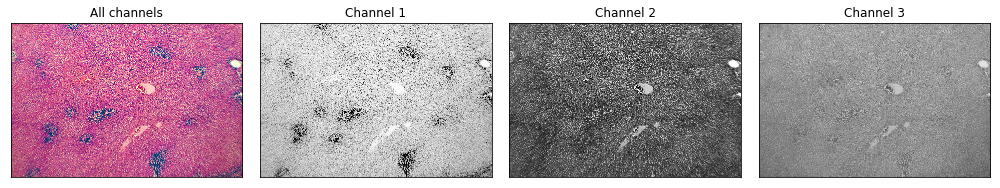

In [90]:
# Load the data
widefield_image_file = "data/Sheep11-4x-77.jpg"
image = transform.rescale(io.imread(widefield_image_file), 0.25)

plot_image(image)

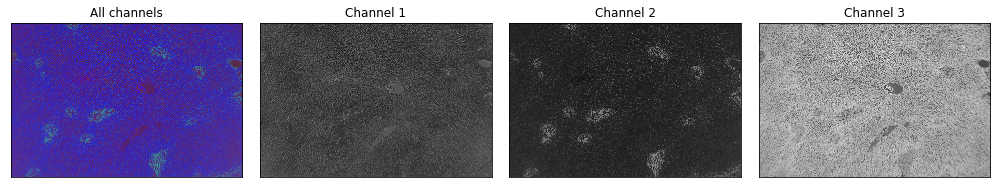

In [81]:
# Perform a colour deconvolution
heu = color.separate_stains(image, colour_deconv_matrix).astype(float)

plot_image(heu)

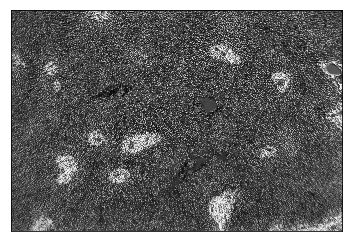

In [82]:
# Apply CLAHE on the haematoxylin channel
rescaled = exposure.rescale_intensity(heu[:, :, 1], out_range=(0, 1))
equalised_hist = exposure.equalize_adapthist(rescaled)

plot_image(equalised_hist)

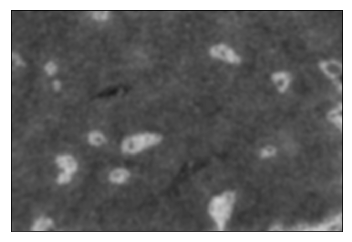

In [83]:
# Apply Gaussian blur
blurred = filters.gaussian(equalised_hist, 7)

plot_image(blurred)

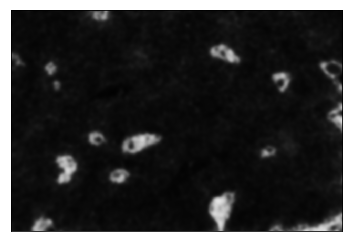

In [84]:
# Sigmoid transform for contrast
contrast = exposure.adjust_sigmoid(blurred, cutoff=0.6)

plot_image(contrast)

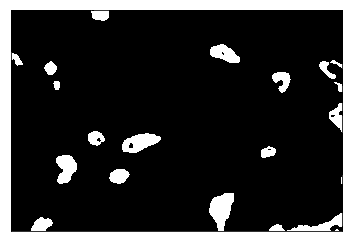

In [85]:
# Apply an adaptive threshold
thresholded = contrast > filters.threshold_local(contrast, 351, offset=-0.1)

plot_image(thresholded)

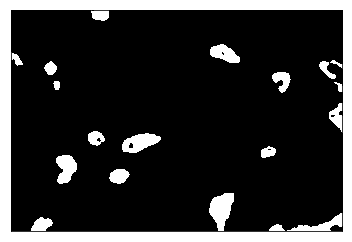

In [86]:
# Remove small connected components, they're likely not inflammatory zones
cleaned = morphology.remove_small_objects(thresholded, 500)

plot_image(cleaned)

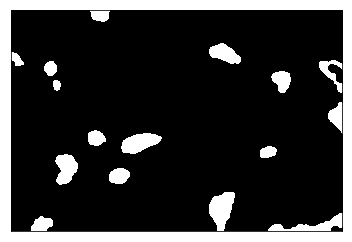

In [87]:
# Use a maximum filter followed by a binary closing to fill any holes
enlarged = maximum_filter(cleaned, 5)
inflammation = morphology.closing(enlarged, morphology.disk(11))

plot_image(inflammation)

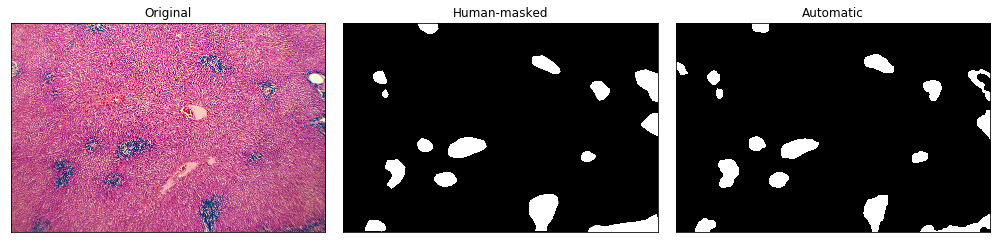

In [120]:
# Load up the human mask and visualise everything together
mask = transform.rescale(io.imread("data/Sheep11-4x-77.jpg_mask.jpg"), 0.25)
all_images = np.dstack((image, mask, inflammation))

plot_image(all_images, titles=["Original", "Human-masked", "Automatic"])

# Extension : a neural network approach

In [157]:
# Let's use a convolutional encoder-decoder network to find inflammatory zones
from keras.models import load_model

model = load_model("models/histo_convnet.hdf5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_206 (Conv2D)          (None, 432, 648, 32)      896       
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 432, 648, 32)      9248      
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 432, 648, 32)      9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 216, 324, 32)      0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 216, 324, 64)      18496     
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 216, 324, 64)      36928     
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 216, 324, 64)      36928     
__________

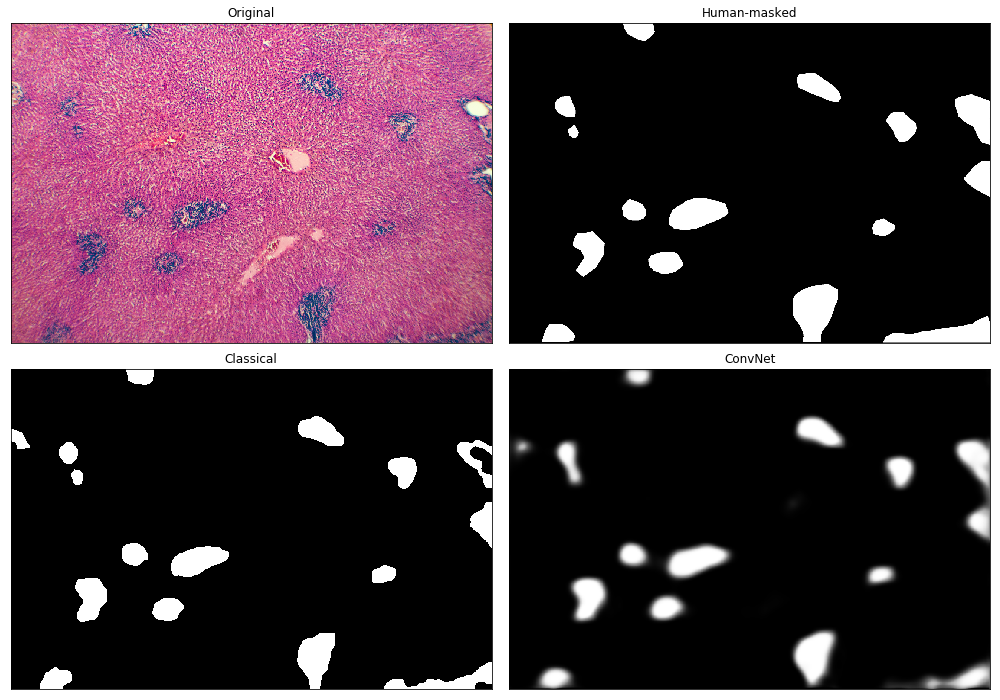

In [156]:
# Use the convnet to find the inflammatory zones, and compare with our work so far
nn_image = transform.rescale(image, 0.5)
pred = model.predict(nn_image.reshape(1, *nn_image.shape)).squeeze()

plot_grid((image, mask, inflammation, pred), ["Original", "Human-masked", "Classical", "ConvNet"])